In [1]:
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist


import matplotlib.pyplot as plt
import seaborn as sns


## 1. Predicting Young modulus as a linear regression problem   

Since $Y = - \frac{il}{2kl\sqrt{Bm'}}$ and having the experimental data. The first approach is to predict the Young's modulus value as a simple regression problem      

In [2]:
beam = {"length": 0.301,
        "width": 0.026,
        "thickness": 0.003,
        "E":10e10,
        #"E": 100000186368, # approach without normalizing
        #"E": 100000194560, # normalized approach
        #"E": 10e11,
        "mass": 0.1877
       }

beam["massPerUnit"] = beam["mass"] / beam["length"]
beam["volume"] = beam["length"] * beam["width"] * beam["thickness"]
beam["I"] = (beam["width"]*beam["thickness"]**3)/12


In [3]:
beam

{'length': 0.301,
 'width': 0.026,
 'thickness': 0.003,
 'E': 100000000000.0,
 'mass': 0.1877,
 'massPerUnit': 0.6235880398671096,
 'volume': 2.3477999999999998e-05,
 'I': 5.849999999999999e-11}

In [23]:
def normalize(x):
    x = (x - x.mean()) / x.std()
    return x

def mobilityFunc(E, freq, beam, eta=0.007):
 
    l = beam["length"]/2

    # calculating the bending wave number
    w = 2*np.pi*freq # Angular frequency
    B = E*beam["I"] #
    complex_B = E*(1+1j*eta)*beam["I"]
    cb = np.sqrt(w)*(B/beam["massPerUnit"])**(1/4) # bending wave velocity
    
    kl = w/(cb)*l # bending wave number
    complex_kl = kl*(1-1j*eta/4)
    N_l = np.cos(complex_kl)*np.cosh(complex_kl) + 1
    D_l = np.cos(complex_kl)*np.sinh(complex_kl) + np.sin(complex_kl)*np.cosh(complex_kl)

    Y = -(1j*l)/ (2*complex_kl*np.sqrt(complex_B *beam["massPerUnit"])) * N_l/D_l
    return abs(Y)
    #Y = -(0.25*eta+1j)*l/(2*kl*np.sqrt(B*beam["massPerUnit"])) * N_l/D_l
    # The mobility is a complex value but just the absolute value is shown 
    #Y = -1j*l/ (2*complex_kl*torch.sqrt(complex_B*beam["massPerUnit"])) d* N_l/D_l)

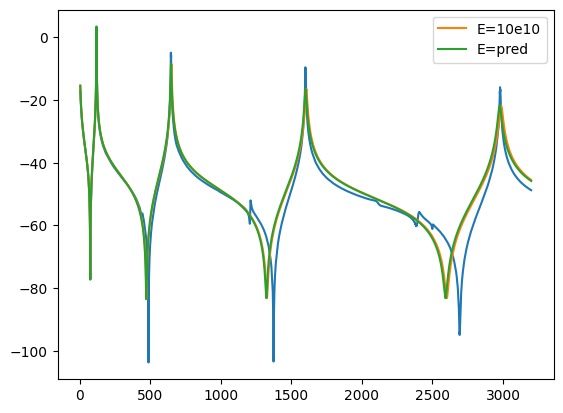

In [25]:
data = pd.read_csv("./Data/bend/centerFreqResponse.csv")[10:]
data["mobility"] = data["force"] + 1j*data["velocity"]
#plt.semilogx(data["freq"], 20*np.log10(abs(data["mobility"])), label="measurement")
norm_exp = abs(data["mobility"])
#norm_exp = (norm_exp - norm_exp.mean()) / norm_exp.std()

Y = mobilityFunc(beam["E"], data["freq"], beam)
Y_pred = mobilityFunc(0.993*10e10, data["freq"], beam)
norm_Y = Y
#norm_Y = (norm_Y - norm_Y.mean()) / norm_Y.std()
plt.plot(data["freq"], 20*np.log10(norm_exp))
#plt.semilogx(data["freq"], 20*np.log10(Y), label="E=10e10")
plt.plot(data["freq"], 20*np.log10(Y), label="E=10e10")
plt.plot(data["freq"], 20*np.log10(Y_pred), label="E=pred")
#plt.xlim([0, 1000])
plt.legend()

/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


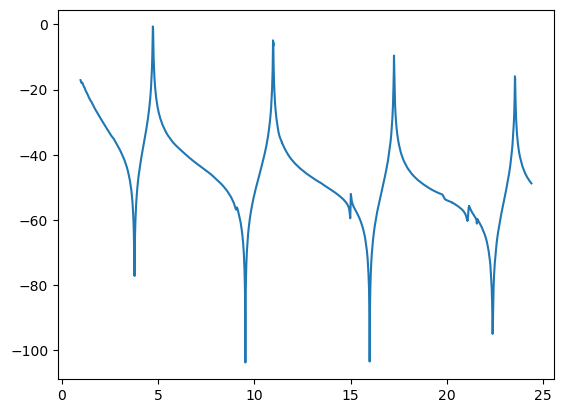

In [7]:
data = pd.read_csv("./Data/bend/centerFreqResponse.csv")[10:]
data["mobility"] = data["force"] + 1j*data["velocity"]

w = 2*np.pi*data["freq"]
B = beam["E"]*beam["I"]
cb = np.sqrt(w)*(B/beam["massPerUnit"])**(1/4)
kl_data = w/cb * (1-1j*(0.0007/4))*beam["length"]

plt.plot(kl_data, 20*np.log10(data["mobility"]))

In [8]:
def mobilityFuncModel(E, freq, beam=beam, eta=0.001):
    l = beam["length"]
    
    E = E.numpy()
    print(E)
    freq = freq
    B = E*beam["I"]
    w = 2*np.pi*freq
    cb = np.sqrt(w)*(B/beam["massPerUnit"])**(1/4)
    kl = w/cb * (1-1j*(eta/4))*beam["length"]
    
    N_l = np.cos(kl)*np.cosh(kl) + 1
    D_l = np.cos(kl)*np.sinh(kl) + np.sin(kl)*np.cosh(kl)
    
    
    Y = -(1j*l/ 2*kl)*(1-1j*eta/4)*l*np.sqrt(B*(1+1j*eta)*beam["massPerUnit"]) * N_l/D_l
    return Y

In [9]:
def model(freq, Y_exp):
    E_theo = 10e10 # theoreticall Young's modulus of brass
    #alpha = pyro.sample("alpha", dist.Normal(Etheo, 1))
    #beta = pyro.sample("beta", dist.Dirichlet(10))
    E = pyro.sample("E", dist.Normal(E_theo, 1.))
    with pyro.plate("data", len(freq)):
        Y = pyro.sample("Y", dist.Normal(mobilityFuncModel(E, freq), 1.), obs=Y_exp)
    return Y
         

In [11]:
from pyro.infer import MCMC, NUTS
import torch
#y_obs = torch.tensor(np.array(data["mobility"])) # Suppose this was the vector of observed y's
#freq = torch.tensor(np.array(data["freq"])).float()
y_obs = np.array(data["mobility"]) # Suppose this was the vector of observed y's
freq = np.array(data["freq"])
# Run inference in Pyro
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=500, num_chains=1)
mcmc.run(freq, y_obs)

# Show summary of inference results
mcmc.summary()

Warmup:   0%|          | 0/1500 [00:00, ?it/s]

100000000000.0


ValueError: Input arguments must all be instances of numbers.Number, torch.Tensor or objects implementing __torch_function__.
Trace Shapes:       
 Param Sites:       
Sample Sites:       
       E dist      |
        value      |
    data dist      |
        value 6391 |

## Maximum A Posteriori estimation


In [127]:
import graphviz
experiment = pd.read_csv("./Data/bend/centerFreqResponse.csv")[10:]
experiment["mobility"] = experiment["force"] + 1j*experiment["velocity"]

w = 2*np.pi*experiment["freq"]
B = beam["E"]*beam["I"]
cb = np.sqrt(w)*(B/beam["massPerUnit"])**(1/4)
kl_data = w/cb * (1-1j*(0.0007/4))*beam["length"]

In [1]:
def mobilityFuncModel(E, beam=beam, eta=0.001):
    l = beam["length"]
    
    E = E.numpy()
    
    freq = experiment["freq"]
    B = E*beam["I"]
    w = 2*np.pi*freq
    cb = np.sqrt(w)*(B/beam["massPerUnit"])**(1/4)
    kl = w/cb * (1-1j*(eta/4))*beam["length"]
    
    N_l = np.cos(kl)*np.cosh(kl) + 1
    D_l = np.cos(kl)*np.sinh(kl) + np.sin(kl)*np.cosh(kl)
    
    
    Y = -(1j*l/ 2*kl)*(1-1j*eta/4)*l*np.sqrt(B*(1+1j*eta)*beam["massPerUnit"]) * N_l/D_l
    return Y

NameError: name 'beam' is not defined

In [143]:
def model(Y_exp):
    E_theo = 10e10 # theoreticall Young's modulus of brass
    # define the hyperparameters that control the Beta prior
    alpha = torch.tensor(E_theo)
    beta = torch.tensor(1.)
    f = pyro.sample("latent_fairness", dist.Normal(alpha, beta)) 
    
    with pyro.plate("data", len(Y_exp)):
        Y = pyro.sample("Y", dist.Bernoulli(mobilityFuncModel(f)), obs=data)

In [144]:
def guide(data):
    Youngs = pyro.param("youngs", torch.tensor(10e10),
                        constraint=dist.unit_interval) #Theoretical value of Young's modulus
    pyro.sample("latent_fairness", dist.Delta(Youngs))

In [145]:
data = torch.tensor(np.array(experiment["mobility"])) # Suppose this was the vector of observed y's
freq = np.array(experiment["freq"])
pyro.render_model(model, model_args=(data,), render_distributions=True)

ValueError: Input arguments must all be instances of numbers.Number, torch.Tensor or objects implementing __torch_function__.
       Trace Shapes:       
        Param Sites:       
       Sample Sites:       
latent_fairness dist      |
               value      |
           data dist      |
               value 6391 |

In [ ]:
# set up the optimizer
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

n_steps = 5000
# do gradient steps
for step in range(n_steps):
    svi.step(data)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices